Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [23]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import re
import zipfile
import bz2
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [24]:
url = ''


def maybe_download(url, filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename +
                        '. Can you get to it with a browser?')
    return filename


files = [
    maybe_download(
        'http://www.evanjones.ca/software/wikipedia2text-extracted.txt.bz2',
        'wikipedia_text.txt.bz2', 18377035),
    maybe_download(
            'http://mattmahoney.net/dc/text8.zip', 'text8.zip', 31344016)
]

Found and verified wikipedia_text.txt.bz2
Found and verified text8.zip


Read the data into a string.

In [27]:
def read_zip_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0]))
        data = re.sub(r'[^A-Za-z0-9\s]+', '', data).lower().split()
    return data

def read_bz2_data(filename):
    with bz2.BZ2File(filename) as f:
        data = tf.compat.as_str(f.read())
        data = re.sub(r'[^A-Za-z0-9\s]+', '', data).lower().split()
    return data

def read_data(filename):
    return {
        'zip': read_zip_data,
        'bz2': read_bz2_data
    }.get(filename[-3:])(filename)

words = []
for i in range(len(files)):
    print(files[i])
    words = words + read_data(files[i])
    print('Data size %d' % len(words))

wikipedia_text.txt.bz2
Data size 10098646
text8.zip
Data size 27103853


Build the dictionary and replace rare words with UNK token.

In [28]:
vocabulary_size = 50000


def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary


data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 808046], ('the', 1851162), ('of', 997495), ('and', 726585), ('in', 642745)]
Sample data [3673, 8, 6, 20267, 188, 2, 4072, 3830, 33, 12334]


Function to generate a training batch for the skip-gram model.

In [29]:
data_index = 0


def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels


print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(
        batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' %
          (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']

with num_skips = 2 and skip_window = 1:
    batch: ['is', 'is', 'a', 'a', 'concerted', 'concerted', 'set', 'set']
    labels: ['propaganda', 'a', 'is', 'concerted', 'set', 'a', 'concerted', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['a', 'a', 'a', 'a', 'concerted', 'concerted', 'concerted', 'concerted']
    labels: ['propaganda', 'concerted', 'set', 'is', 'set', 'of', 'is', 'a']


Train a skip-gram model.

In [30]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64  # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal(
            [vocabulary_size, embedding_size],
            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    print(embed)
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                   train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                              valid_dataset)
    similarity = tf.matmul(valid_embeddings,
                           tf.transpose(normalized_embeddings))

Tensor("embedding_lookup:0", shape=(128, 128), dtype=float32)


In [31]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips,
                                                  skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.358517
Nearest to people: progesterone, syntactical, sewerage, uncontroversial, soaps, shirt, hooves, bicycle,
Nearest to an: petrovich, river, figure, astute, mushrooms, greece, fsb, philosophies,
Nearest to are: transactions, business, reproducing, pico, aloe, alfonso, cindy, rechargeable,
Nearest to years: faber, carney, luce, vigorous, stacked, droplets, trope, unto,
Nearest to these: eno, introductory, lorenzo, battle, horton, nationalism, palin, anxiety,
Nearest to they: spears, fetishes, prolonging, honsh, redding, nineteenthcentury, anterior, radioisotopes,
Nearest to seven: jizya, bicentennial, phnom, tm, kruger, gregory, thailand, lambs,
Nearest to as: cetaceans, ttir, friedmans, carnot, diary, outfits, waterline, tikal,
Nearest to to: edmontons, discharging, stretches, offering, dividing, donald, calvinism, goguryeo,
Nearest to only: tates, muon, fausta, theory, pfizer, scythian, proven, quiet,
Nearest to four: noncommunist, dwellings, d

In [32]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

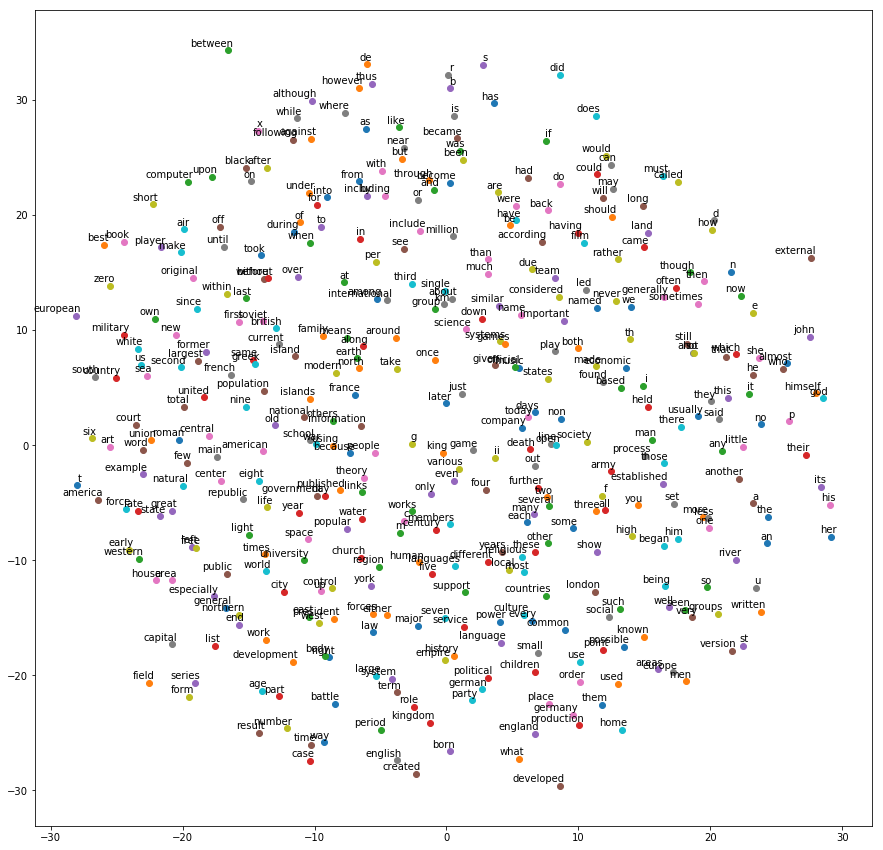

In [33]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [37]:
data_index = 0

def generate_continuous_bag_of_batch(batch_size, window):
    global data_index
    batch = np.ndarray(shape=(batch_size, window*2), dtype=np.ndarray)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    for i in range(batch_size):
        midpoint = data_index + window
        batch[i] = np.array(data[data_index:midpoint] + data[midpoint+1:midpoint+window+1])
        labels[i] = data[midpoint]
        data_index = (data_index + 1) % (len(data) - window * 2 - 2)
            
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:9]])

for window_size in [2, 4]:
    data_index = 0
    batch, labels = generate_continuous_bag_of_batch(20, window_size)
    print('\nwith window = %d' % (window_size))
    print('    batch:', [reverse_dictionary[bi] for bi in batch[0]])
    print('    labels:', reverse_dictionary[labels[0][0]])

data: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at']

with window = 2
    batch: ['propaganda', 'is', 'concerted', 'set']
    labels: a

with window = 4
    batch: ['propaganda', 'is', 'a', 'concerted', 'of', 'messages', 'aimed', 'at']
    labels: set


In [38]:
batch_size = 128
embedding_size = 1024 # Dimension of the embedding vector.
window_size = 5
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 128 # Number of negative examples to sample.

for sample in valid_examples:
    print(reverse_dictionary[sample], end=', ')

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, window_size*2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    avg_embed =  tf.reduce_mean(embed, 1, keep_dims=False)
    # Compute the softmax loss, using a sample of the negative labels each time.
    soft_loss = tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, avg_embed, train_labels, num_sampled, vocabulary_size)
    loss = tf.reduce_mean(soft_loss)

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

both, three, first, system, called, many, these, not, state, than, no, city, he, her, most, world, 

In [44]:
num_steps = 1000001
print_step = 10000
summary_step = 100000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_continuous_bag_of_batch(
            batch_size, window_size)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % print_step == 0:
            if step > 0:
                average_loss = average_loss / print_step
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % summary_step == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.381725
Nearest to both: laser, channing, grafton, attempting, corman, masculism, aggressors, sequencer,
Nearest to three: tracking, luzon, sm, reconquered, 87, carbohydrate, retardation, small,
Nearest to first: foe, grim, symplectic, trachea, kellogg, devices, nbc, formula,
Nearest to system: occupancy, persisting, unseen, koala, denunciation, allafrica, gizmo, mineralogy,
Nearest to called: magnetic, welder, autochthonous, beatrix, minnesota, walnut, hashemite, dies,
Nearest to many: ibadi, anomalies, conceptions, emigr, cayley, immigrate, copying, emblem,
Nearest to these: transfer, ial, verde, vitro, preservation, pls, affluent, hexagon,
Nearest to not: argon, hilary, ventures, andean, perrin, afrikaans, plessy, simpler,
Nearest to state: colspan, airplane, heats, geirr, serra, brecht, sarpedon, photographed,
Nearest to than: latte, inelastic, colter, piping, 1837, listed, mccarthyism, bengali,
Nearest to no: curries, sharpness, inductive, yiel

In [45]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

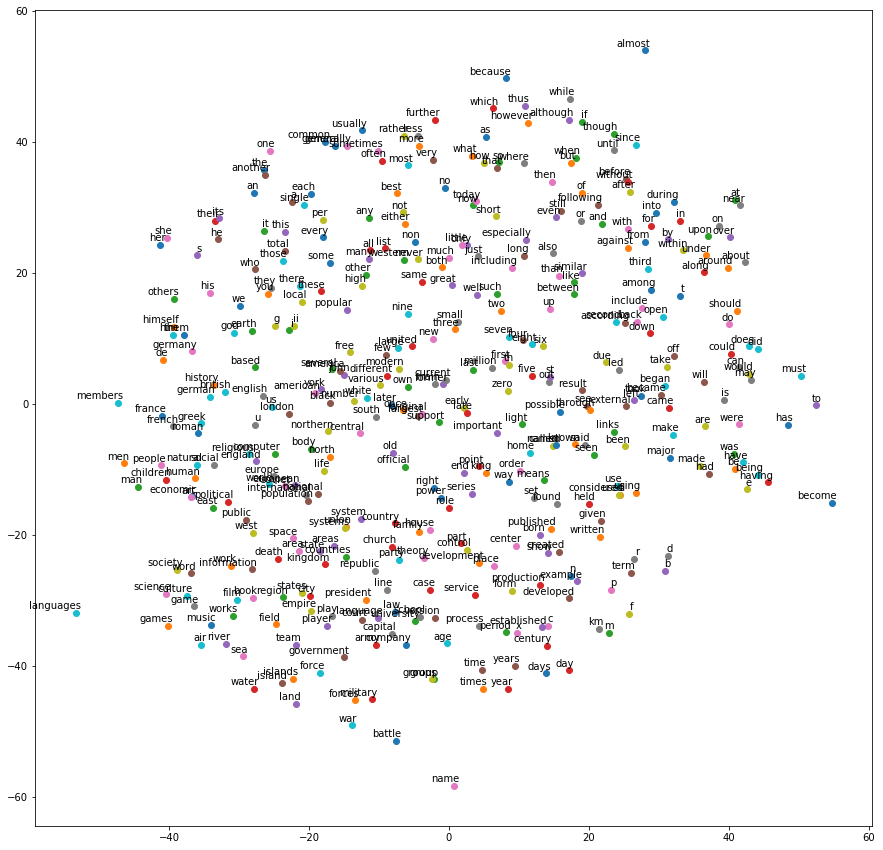

In [46]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)